Learn the corrected Jacobi iterator (H) for single-phase problems 
* The iterator is shared by different grids 
* Dataset is constructed by changing RHS & Dirichlet boundary conditions
* Restriction and Prolongation kernels are assumed to be the linear

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from functools import reduce

from FEANet.mesh import MeshSquare
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet

from Utils import plot
from Data.dataset import IsoPoissonDataSet

In [2]:
def compute_q(res_arr):
    return res_arr[-1]/res_arr[-2]

In [3]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def ResetBoundary(self, bc_idx, bc_values):
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, bc_idx, bc_values)

    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

In [4]:
class HNet(nn.Module):
    def __init__(self, nb_layers):
        super(HNet, self).__init__()

        self.convLayers = nn.ModuleList([nn.Conv2d(1, 1, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, x, geo_idx):
        '''geo_idx: internal points 1; boundary points 0'''
        return reduce(lambda acc, el: el(acc) * geo_idx, self.convLayers, x)

In [5]:
class HJacIterator(nn.Module):
    def __init__(self, 
                 n,
                 size=2, 
                 hnet=None,
                 grid=None,
                 batch_size=5,
                 max_epochs=1000,
                 nb_layers=3,
                 model_name='iso_poisson_33x33',
                 model_dir='Model/learn_iterator/iso_poisson'):
        super(HJacIterator, self).__init__()
        self.size = size
        self.n = n
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss(reduction='sum')
        
        if(grid is None):
            self.grid = SingleGrid(size, n)
        else:
            self.grid = grid

        if(hnet is None):
            self.net = HNet(nb_layers)
        else:
            self.net = hnet

        self.optimizer = torch.optim.Adadelta(self.net.parameters())
        self.model_dir=model_dir
        self.model_name=model_name

    def HRelax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of modified Jacobi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(u, f)
            u = jac_it + self.net(jac_it-u, self.grid.jac.geometry_idx)
        return u

    def RandomSampling(self, x):
        u = torch.randn_like(x)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            u_train, f_train, bc_value_train, bc_index_train = data
        
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = random.randint(1,20)

            self.grid.ResetBoundary(bc_index_train, bc_value_train)
            ff = self.grid.fnet(f_train)
            uu = self.RandomSampling(f_train)
            
            u_out = self.HRelax(uu, ff, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,self.model_name+'.pth')
            torch.save(self.net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train


In [6]:
# import the learned model
model_name = 'iso_poisson_33x33'
model_dir = 'Model/learn_iterator/iso_poisson'

my_hnet = HNet(nb_layers=3)
my_hnet.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))

<All keys matched successfully>

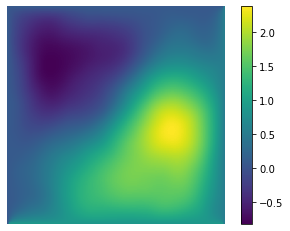

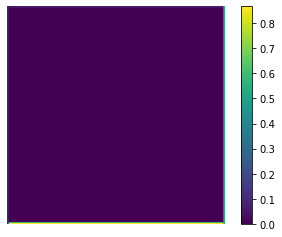

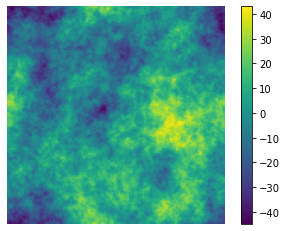

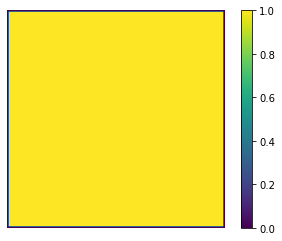

In [7]:
# test on larger grid
test_set = IsoPoissonDataSet('Data/IsoPoisson/poisson2d_129x129.h5')
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)
u_test, f_test, bc_value_test, bc_index_test = next(iter(test_dataloader))

k=0
plot.plot_field(u_test[k,0])
plot.plot_field(bc_value_test[k,0])
plot.plot_field(f_test[k,0])
plot.plot_field(bc_index_test[k,0])

In [8]:
n = 2**7
test_iterator = HJacIterator(hnet=my_hnet, n=n)
test_iterator.requires_grad_(False)

HJacIterator(
  (loss): MSELoss()
  (net): HNet(
    (convLayers): ModuleList(
      (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
)

In [9]:
EPS = 5e-5
n_jac = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = test_iterator.grid.fnet(f_test[k,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
test_iterator.grid.ResetBoundary(bc_index_test[k,0].reshape((1,1,n+1,n+1)), bc_value_test[k,0].reshape((1,1,n+1,n+1)))
u_test = test_iterator.grid.jac.reset_boundary(u_test)
residual = f_test-test_iterator.grid.Knet(u_test)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
res_arr_test = [res]
print(n_jac, res)

start = time.time()
while (abs(res) > EPS):
    u_test = test_iterator.grid.jac.jacobi_convolution(u_test, f_test)
    residual = f_test-test_iterator.grid.Knet(u_test)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr_test.append(res)
    n_jac += 1
    print(n_jac, res)
end = time.time()

print("Solution converges after", n_jac, "Jacobi iterations in", end-start, 'seconds.')

0 11.552556037902832
1 6.4573469161987305
2 4.678605556488037
3 3.739846706390381
4 3.150202751159668
5 2.7416813373565674
6 2.440154552459717
7 2.207512378692627
8 2.0220296382904053
9 1.8703596591949463
10 1.7438217401504517
11 1.6365106105804443
12 1.544260859489441
13 1.464045524597168
14 1.3936079740524292
15 1.331229567527771
16 1.275577425956726
17 1.2256007194519043
18 1.1804587841033936
19 1.139471411705017
20 1.1020811796188354
21 1.0678274631500244
22 1.0363253355026245
23 1.007251501083374
24 0.9803311824798584
25 0.9553301930427551
26 0.932047426700592
27 0.9103087782859802
28 0.8899633884429932
29 0.8708792924880981
30 0.85294109582901
31 0.8360466361045837
32 0.8201060891151428
33 0.8050394058227539
34 0.7907753586769104
35 0.7772504687309265
36 0.7644075155258179
37 0.7521952986717224
38 0.7405675649642944
39 0.7294822335243225
40 0.7189016938209534
41 0.7087913155555725
42 0.6991197466850281
43 0.6898584961891174
44 0.6809811592102051
45 0.6724637746810913
46 0.6642844

In [10]:
EPS = 5e-5
n_jac_test = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = test_iterator.grid.fnet(f_test[k,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
test_iterator.grid.ResetBoundary(bc_index_test[k,0].reshape((1,1,n+1,n+1)), bc_value_test[k,0].reshape((1,1,n+1,n+1)))
u_test = test_iterator.grid.jac.reset_boundary(u_test)
residual = f_test-test_iterator.grid.Knet(u_test)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
res_arr_testnew = [res]
print(n_jac_test, res)

start = time.time()
while (abs(res) > EPS):
    n_jac_test += 1
    u_test = test_iterator.HRelax(u_test, f_test, 1)
    residual = f_test-test_iterator.grid.Knet(u_test)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr_testnew.append(res)
    print(n_jac_test, res)
end = time.time()

print("Solution converges after", n_jac_test, "modified Jacobi iterations in", end-start, 'seconds.')

0 11.564170837402344
1 3.374000310897827
2 1.3720762729644775
3 0.8033679723739624
4 0.5990258455276489
5 0.4978753626346588
6 0.43310531973838806
7 0.3859931528568268
8 0.349506676197052
9 0.32017362117767334
10 0.2959718108177185
11 0.2756056785583496
12 0.25819486379623413
13 0.24311557412147522
14 0.22991155087947845
15 0.21824060380458832
16 0.20784035325050354
17 0.19850635528564453
18 0.19007641077041626
19 0.18242023885250092
20 0.1754319816827774
21 0.16902442276477814
22 0.16312545537948608
23 0.15767422318458557
24 0.15261970460414886
25 0.14791852235794067
26 0.1435333490371704
27 0.13943205773830414
28 0.1355869174003601
29 0.13197356462478638
30 0.12857100367546082
31 0.1253604292869568
32 0.12232543528079987
33 0.11945144832134247
34 0.11672541499137878
35 0.11413566768169403
36 0.11167196929454803
37 0.10932479798793793
38 0.1070859357714653
39 0.10494761168956757
40 0.10290294885635376
41 0.10094567388296127
42 0.09907006472349167
43 0.0972708985209465
44 0.09554343670

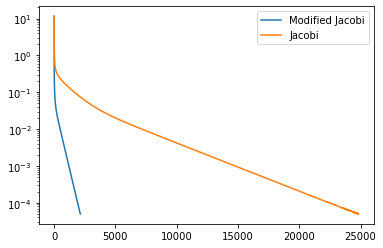

In [11]:
plt.plot(res_arr_testnew, label='Modified Jacobi')
plt.plot(res_arr_test, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()

In [12]:
def heatmap2d(arr):
    plt.imshow(arr,cmap='viridis')
    plt.colorbar()
    plt.gcf()
    plt.show()

In [13]:
def conv_op(k1, k2, max_size=7):
    '''Perform convolution operation in infinite domain'''
    size1 = k1.shape[0]
    size2 = k2.shape[0]
    
    pad1 = int((max_size-size1)/2)
    pad2 = int((max_size-size2)/2)

    k1_pad = F.pad(k1,(pad1,pad1,pad1,pad1))
    k2_pad = F.pad(k2,(pad2,pad2,pad2,pad2))
    delta = int(max_size/2)

    out_k = torch.zeros((max_size,max_size))
    for u in range(-delta, -delta+max_size):
        for v in range(-delta, -delta+max_size):
            for i in range(-delta, -delta+max_size):
                for j in range(-delta, -delta+max_size):
                    ii = u-i 
                    jj = v-j 
                    multiplier = 0.0
                    if(ii >= -delta and ii <= delta and jj >= -delta and jj <= delta):
                        multiplier = k1_pad[ii+delta,jj+delta]
                    out_k[u+delta,v+delta] += multiplier * k2_pad[i+delta,j+delta]

    return out_k

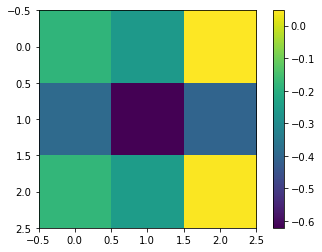

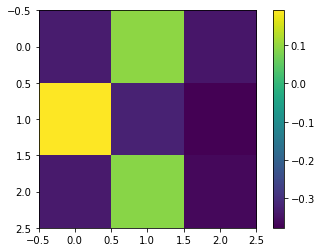

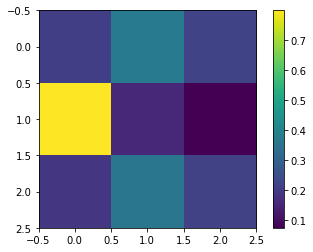

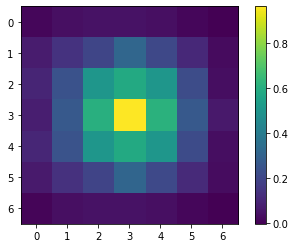

In [22]:
# plot the combined kernel
mlist = list(my_hnet.parameters())
kernel1 = conv_op(mlist[0].view(3,3).detach(), mlist[1].view(3,3).detach(), max_size=5)
kernel2 = conv_op(kernel1, mlist[2].view(3,3).detach(), max_size=7)
kernel2 = kernel2.reshape(1,1,7,7)
heatmap2d(mlist[0].view(3,3).detach().numpy())
heatmap2d(mlist[1].view(3,3).detach().numpy())
heatmap2d(mlist[2].view(3,3).detach().numpy())
heatmap2d(kernel2.view(7,7).detach().numpy())

In [15]:
class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, tensor_R):
        super(RestrictionNet, self).__init__()
        self.n_channel = 1
        self.net = nn.Conv2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][0][i] = tensor_R
    def forward(self, x_split):
        return self.net(x_split)


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, tensor_P):
        super(ProlongationNet, self).__init__()
        self.n_channel = 1
        self.net = nn.ConvTranspose2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][i][0] = tensor_P
            
    def forward(self, x_split): 
        return self.net(x_split)

In [16]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, hnet, P, mode = 'jac'):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.hnet = hnet
        self.mode = mode
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.iterators = self.IteratorDict() # dictionary of iterators
        
        # Inter-grid communication network models
        self.conv = RestrictionNet(P)
        self.deconv = ProlongationNet(P)
        
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)

        self.mse_loss = nn.MSELoss()
    
    def IteratorDict(self):
        iterators = {}
        for i in range(self.L):
            iterators[i] = HJacIterator(size=self.size, hnet=self.hnet, n=self.n_arr[i])
        return iterators        
            
    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        Note: rF has already been splitted
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        Note: eFC has already been splitted
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def loss(self, uk, k):
        "Compute the loss after k iterations, uk is current solution"
        res_k = self.f - self.iterators[0].grid.Knet(uk)
        res_last = self.f - self.iterators[0].grid.Knet(self.last_v)
        return torch.mean(torch.norm(res_k[:, :, 1:-1, 1:-1].clone(), dim=(2,3))/torch.norm(res_last[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).detach())

    '''
    def loss(self, uk, u_star):
        "Compute the loss"
        #err = u.clone() - u_star
        #return torch.mean(torch.norm(err, dim=(2,3)))
        return self.mse_loss(uk, u_star)
    '''

    def forward(self, u0, F, bc_idx, bc_value, k):
        '''Input is initial solution u0, RHS field F, boundary value B, iteration number k'''
        self.f = self.iterators[0].grid.fnet(F) # assign the finest rhs 
        self.iterators[0].grid.ResetBoundary(bc_idx, bc_value) # reset the boundary of finest grid
        self.u0 = self.iterators[0].grid.jac.reset_boundary(u0)
        U = self.u0.clone()
        
        for i in range(k-1):
            U = self.Step(U, self.f).detach()
        self.last_v = U.clone()
        return self.Step(U, self.f)

    def Relax(self, iter, u, f, n_iter):
        if(self.mode == 'jac'):
            return iter.grid.jac.jacobi_convolution(u, f)
        else:
            return iter.HRelax(u, f, n_iter)

    def Step(self, v, f):
        '''Input v is the initial solution on the finest grid'''
        n_batches = v.shape[0]
        n_relax = 1 # number of relaxations
        self.iterators[0].grid.v = v
        self.iterators[0].grid.f = f
        self.iterators[0].grid.v = self.Relax(self.iterators[0], self.iterators[0].grid.v, self.iterators[0].grid.f, n_relax)

        for j in range(0, self.L-1):
            rF = self.iterators[j].grid.f-self.iterators[j].grid.Knet(self.iterators[j].grid.v)
            rF = self.iterators[j].grid.Knet.split_x(rF)
            self.iterators[j+1].grid.f = self.Restrict(rF)
            self.iterators[j+1].grid.v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False)
            self.iterators[j+1].grid.v = self.Relax(self.iterators[j+1], self.iterators[j+1].grid.v, self.iterators[j+1].grid.f, n_relax)

        self.iterators[self.L-1].grid.v = self.Relax(self.iterators[self.L-1], self.iterators[self.L-1].grid.v, self.iterators[self.L-1].grid.f, n_relax)

        for j in range(self.L-2,-1,-1):
            eFC = self.iterators[j+1].grid.Knet.split_x(self.iterators[j+1].grid.v)
            eF_delta = self.Interpolate(eFC)
            self.iterators[j].grid.v = self.iterators[j].grid.v + eF_delta
            self.iterators[j].grid.v = self.Relax(self.iterators[j], self.iterators[j].grid.v, self.iterators[j].grid.f, n_relax)

            # zero out the previous level solution
            self.iterators[j+1].grid.v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False) 

        return self.iterators[0].grid.v 

In [17]:
linear_tensor_P = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 4.0

In [18]:
EPS = 5e-5
n = 2**7
mg_jac = MultiGrid(n=n, hnet=my_hnet, P=linear_tensor_P, mode='jac') # create a multigrid model
n_multigrid = 0
f_mg = f_test[k,0].reshape((1,1,n+1,n+1))
#u_mg = random_sampling(f_mg)
u_mg = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
bc_idx_mg = bc_index_test[k,0].reshape((1,1,n+1,n+1))
bc_value_mg = bc_value_test[k,0].reshape((1,1,n+1,n+1))
mg_jac(u_mg, f_mg, bc_idx_mg, bc_value_mg, 1)
residual = mg_jac.f-mg_jac.iterators[0].grid.Knet(mg_jac.u0)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
err_occured = False
res_arr_mgjac = [res]
print(n_multigrid, res)

start = time.time()
while (abs(res) > EPS):
    u_mg = mg_jac.Step(u_mg, mg_jac.f)
    residual = mg_jac.f-mg_jac.iterators[0].grid.Knet(u_mg)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr_mgjac.append(res)
    n_multigrid += 1
    print(n_multigrid, res)

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations in", end-start, 'seconds.')

#print("Multigrid solution:")
#plot.plot_field(u_mg.detach())

#print("Solution from dataset:")
#plot.plot_field(u_test[k,0].detach())

0 11.56417465209961
1 2.5682945251464844
2 0.6261867880821228
3 0.1542567014694214
4 0.038274019956588745
5 0.009554658085107803
6 0.0023980801925063133
7 0.0006047793431207538
8 0.00015333386545535177
9 3.939303132938221e-05
Solution converges after 9 multi-grid iterations in 0.03221607208251953 seconds.


In [19]:
EPS = 5e-5
n = 2**7
mg_hjac = MultiGrid(n=n, hnet=my_hnet, P=linear_tensor_P, mode='hjac') # create a multigrid model
n_multigrid = 0
f_mg = f_test[k,0].reshape((1,1,n+1,n+1))
#u_mg = random_sampling(f_mg)
u_mg = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
bc_idx_mg = bc_index_test[k,0].reshape((1,1,n+1,n+1))
bc_value_mg = bc_value_test[k,0].reshape((1,1,n+1,n+1))
mg_hjac(u_mg, f_mg, bc_idx_mg, bc_value_mg, 1)
residual = mg_hjac.f-mg_hjac.iterators[0].grid.Knet(mg_hjac.u0)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
err_occured = False
res_arr_mghjac = [res]
print(n_multigrid, res)

start = time.time()
while (abs(res) > EPS):
    u_mg = mg_hjac.Step(u_mg, mg_hjac.f)
    residual = mg_hjac.f-mg_hjac.iterators[0].grid.Knet(u_mg)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr_mghjac.append(res)
    n_multigrid += 1
    print(n_multigrid, res)

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break
end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations in", end-start, 'seconds.')

#print("Multigrid solution:")
#plot.plot_field(u_mg.detach())

#print("Solution from dataset:")
#plot.plot_field(u_test[k,0].detach())

0 11.56417465209961
1 1.0636106729507446
2 0.08906842768192291
3 0.009424089454114437
4 0.0010494871530681849
5 0.00011825918772956356
6 1.570197673572693e-05
Solution converges after 6 multi-grid iterations in 0.036122798919677734 seconds.


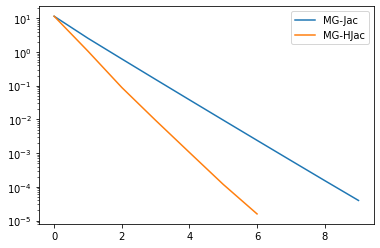

In [20]:
plt.plot(res_arr_mgjac, label="MG-Jac")
plt.plot(res_arr_mghjac, label="MG-HJac")
plt.yscale('log')
plt.legend()
plt.show()

In [21]:
print("q of MG-Jac is: ", compute_q(res_arr_mgjac))
print("q of MG-HJac is: ", compute_q(res_arr_mghjac))

q of MG-Jac is:  0.2569101823162007
q of MG-HJac is:  0.13277595624649804
